In [125]:
# -*- coding: utf-8 -*-
'''Sample script for solar array image classification

Author:       Kyle Bradbury
Date:         January 30, 2018
Organization: Duke University Energy Initiative
'''

'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from skimage.filters import prewitt
import cv2
import matplotlib.image as mpimg
from PIL import Image
from PIL import ImageOps
from scipy.ndimage import rotate

In [103]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './training/'
dir_test_images   = './testing/'
dir_train_labels  = './labels_training.csv'
dir_test_ids      = './sample_submission.csv'

### Data Augmentation

In [18]:
def show_img(img, ax):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
    
def plot_grid(imgs, nrows, ncols, figsize=(10, 10)):
    assert len(imgs) == nrows*ncols, f"Number of images should be {nrows}x{ncols}"
    _, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_img(img, ax)

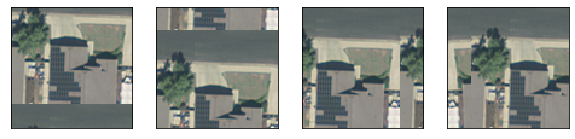

In [19]:
def translate(img, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img


plot_grid([translate(img, direction='up', shift=20),
           translate(img, direction='down', shift=20), 
           translate(img, direction='left', shift=20),
           translate(img, direction='right', shift=20)],
           1, 4, figsize=(10, 5))

In [29]:
translate(img, direction='up', shift=20).shape

(101, 101, 3)

In [145]:
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        
        image_rot90 = rotate(image, 90, reshape=False)
        image_rot180 = rotate(image, 180, reshape=False)
        image_rot270 = rotate(image, 270, reshape=False)
        data.append(image)
        data.append(image_rot90)
        data.append(image_rot180)
        data.append(image_rot270)

        #image_trans = translate(image, direction='up', shift=20)
        #data.append(image_trans)
        
    data = np.array(data) # Convert to Numpy array
    
    if training:
        labels = labels_pd.label.values
        labels = np.repeat(labels, repeats=4, axis=0)
        return data, labels
    else:
        return data, ids

In [130]:
data, labels = load_data(dir_train_images, dir_train_labels, training=True)

In [146]:
data.shape

(6000, 101, 101, 3)

In [147]:
labels.shape

(6000,)

In [83]:
for i in range(12,24):
    print(labels[i])

1
1
1
1
1
1
1
1
0
0
0
0


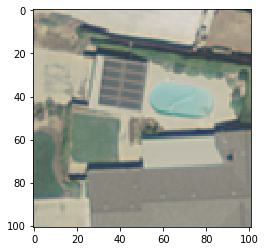

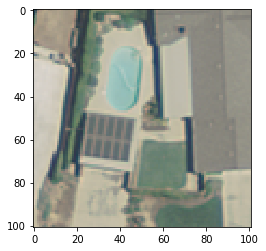

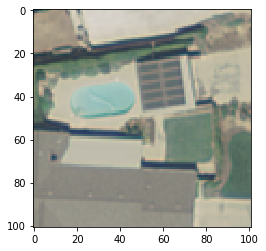

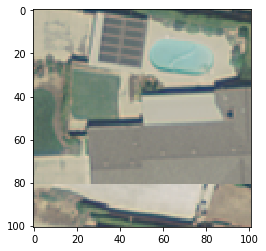

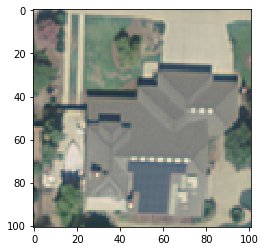

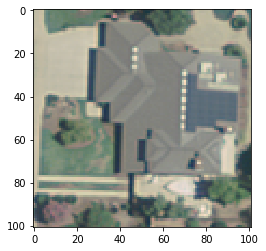

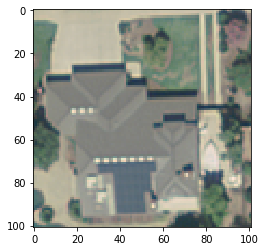

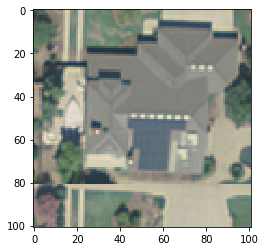

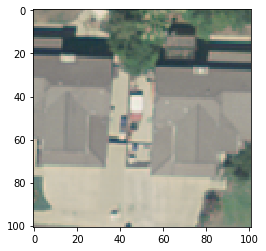

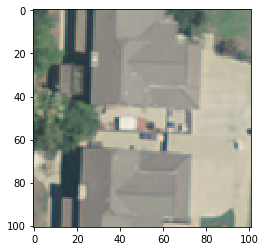

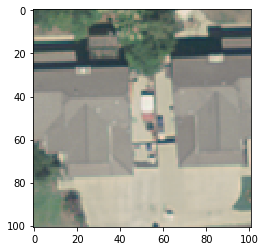

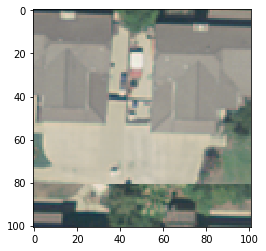

In [84]:
for i in range(12,24):
    plt.imshow(data[i])
    plt.show()

In [88]:
focus = data[2]
focus.shape

(101, 101, 3)

In [89]:
focus_2d = focus.sum(axis=2)
focus_2d_0 = focus[:, :, 0]
focus_2d_1 = focus[:, :, 1]
focus_2d_2 = focus[:, :, 2]

In [90]:
focus_2d_25 = (focus_2d < 200).astype(int)

In [107]:
 def checkPlot(focus_2d):
    plt.imshow((focus_2d[:, :] < 3*120) * (focus_2d[:, :]> 3*110) )
    plt.show()
    plt.imshow((focus_2d[:, :] < 3*110) * (focus_2d[:, :]> 3*100) )
    plt.show()
    plt.imshow((focus_2d[:, :] < 3*100) * (focus_2d[:, :]> 3*90) )
    plt.show()
    plt.imshow((focus_2d[:, :] < 3*90) * (focus_2d[:, :]> 3*80) )
    plt.show()
    plt.imshow((focus_2d[:, :] < 3*80) * (focus_2d[:, :]> 3*70) )
    plt.show()
    plt.imshow((focus_2d[:, :] < 3*70) * (focus_2d[:, :]> 3*60) )
    plt.show()
    print ('\n\n\n')

In [109]:
from scipy import signal

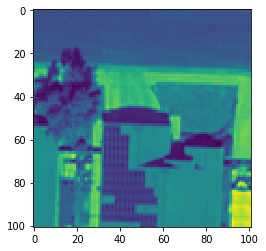

In [111]:
focus_2d = data[2].sum(axis=2)
plt.imshow(focus_2d)

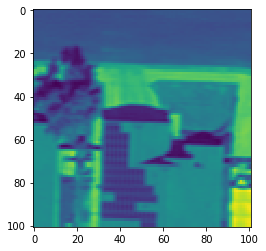

In [114]:
kernel = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]])
grad = signal.convolve2d(focus_2d, kernel, boundary='symm', mode='same')
plt.imshow(grad)

0


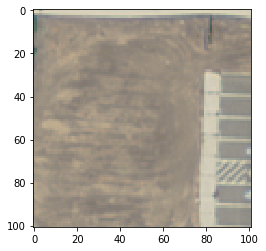

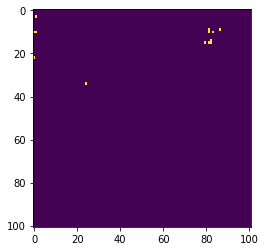

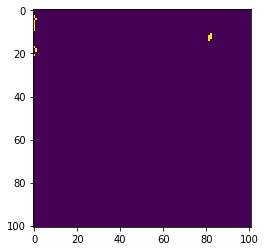

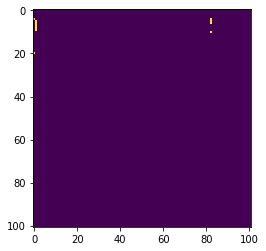

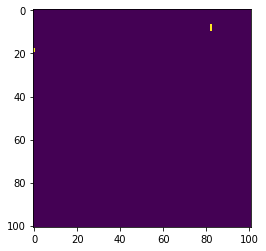

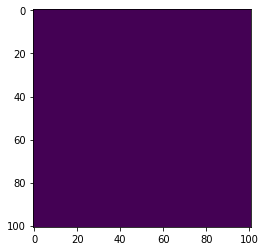

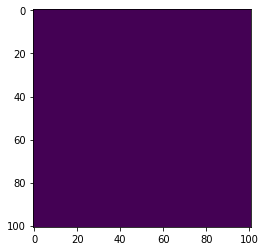






1


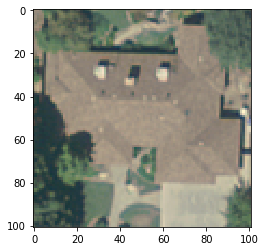

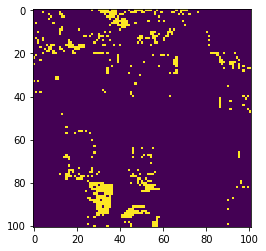

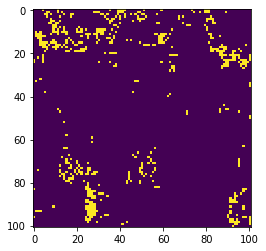

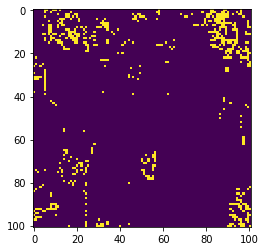

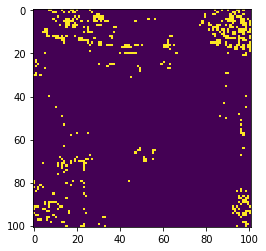

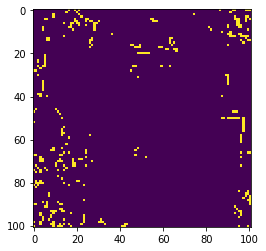

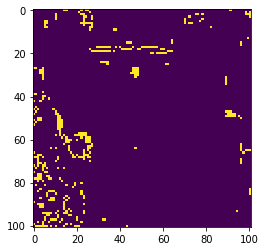






2


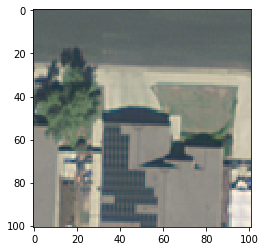

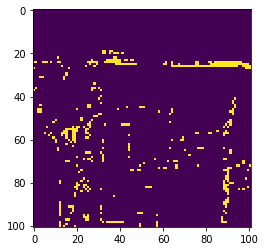

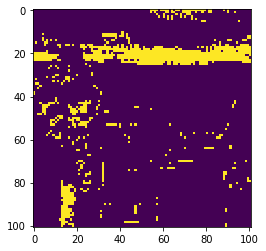

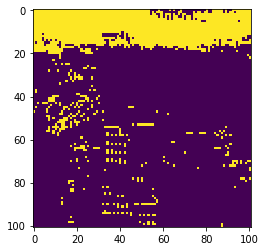

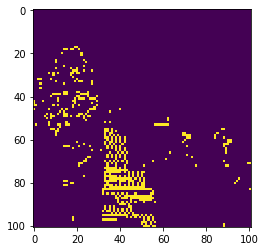

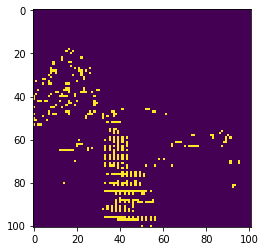

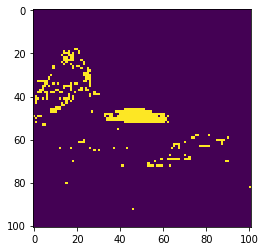






3


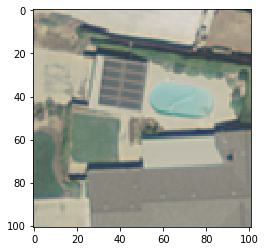

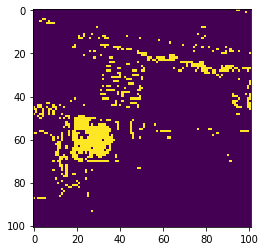

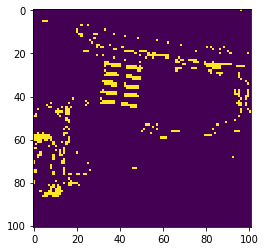

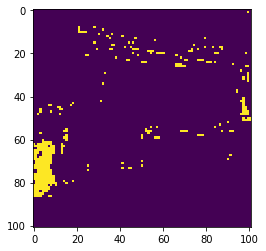

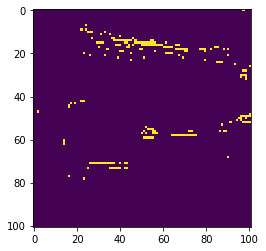

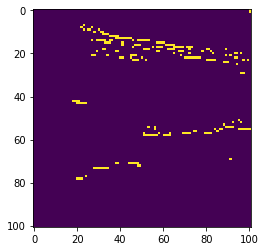

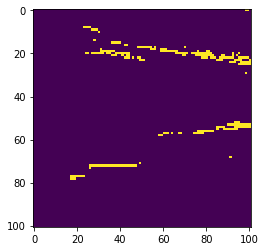






4


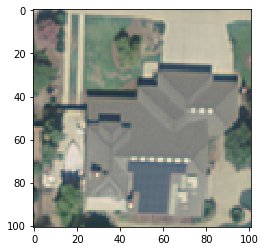

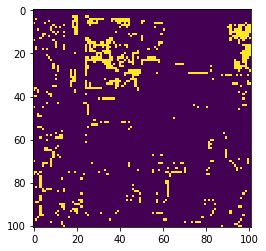

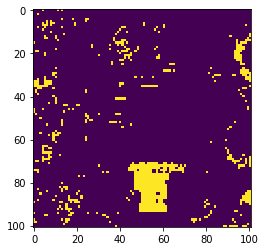

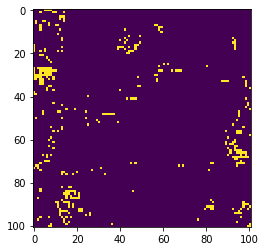

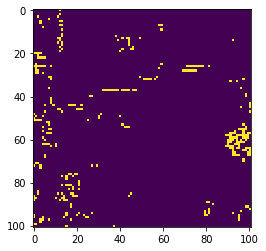

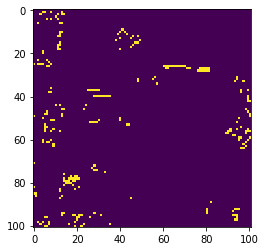

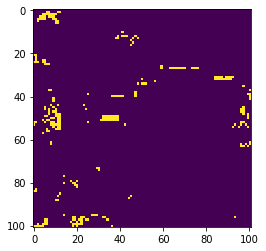






5


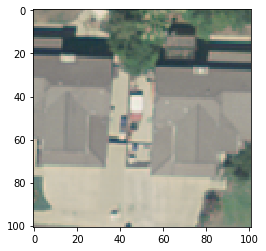

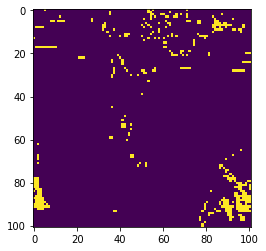

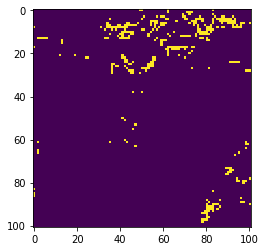

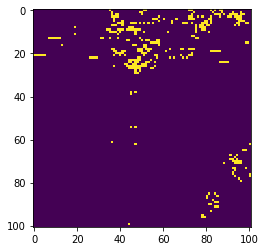

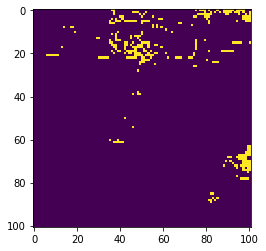

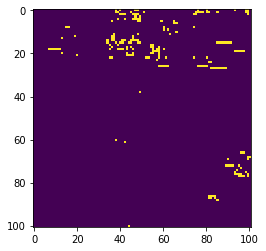

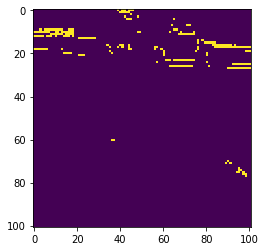






6


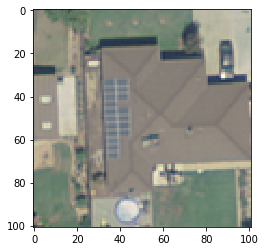

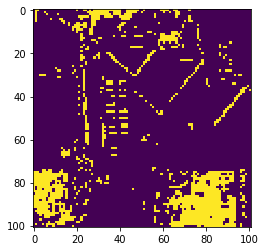

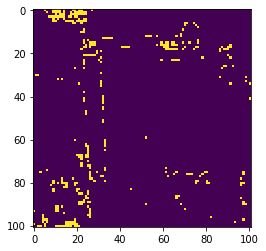

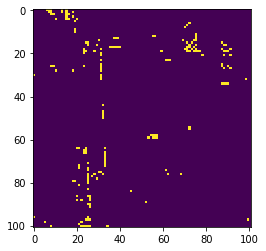

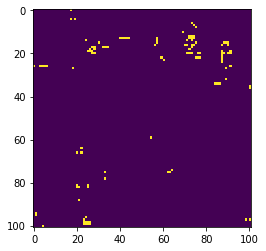

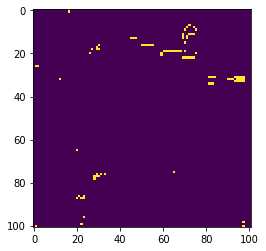

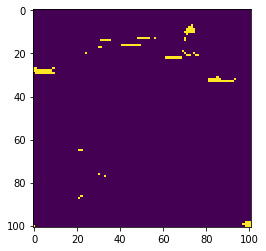






7


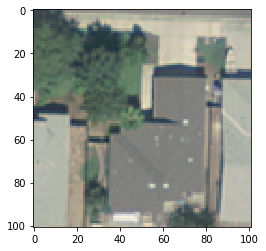

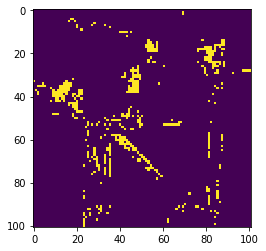

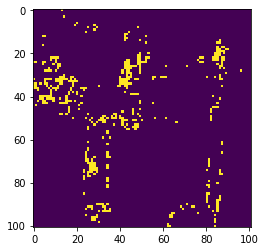

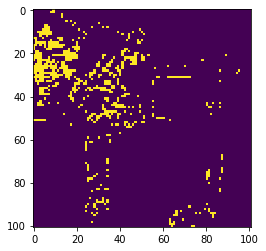

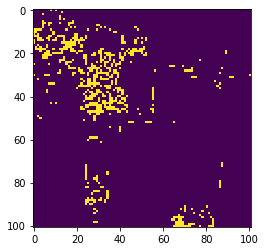

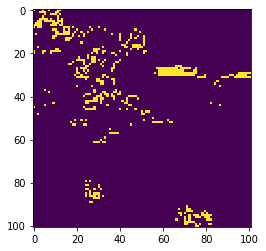

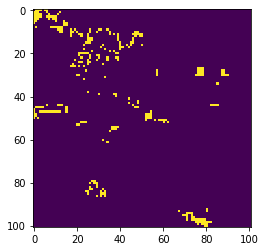






8


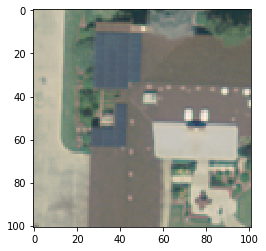

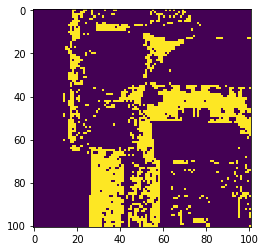

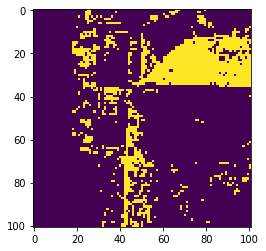

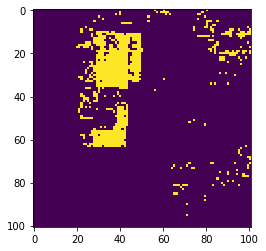

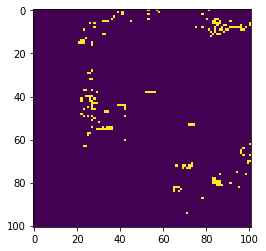

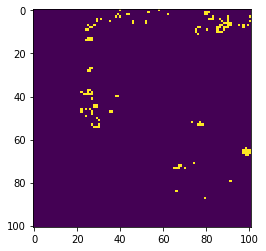

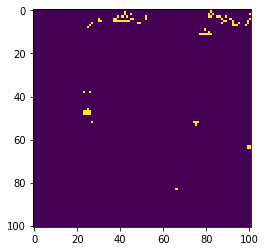






9


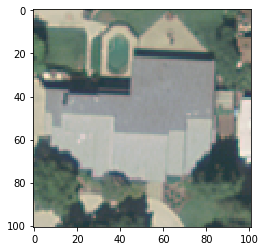

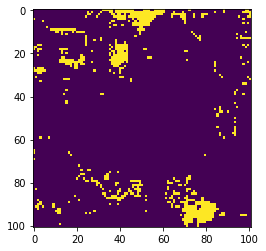

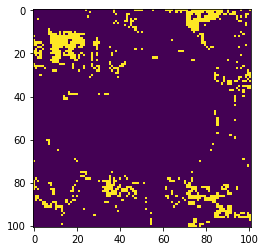

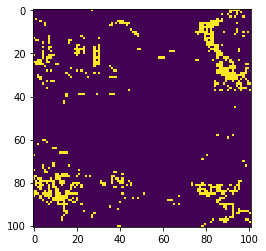

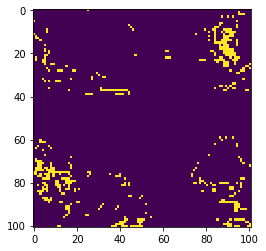

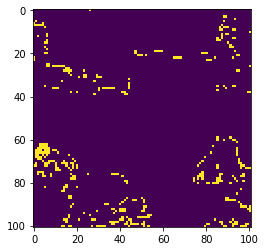

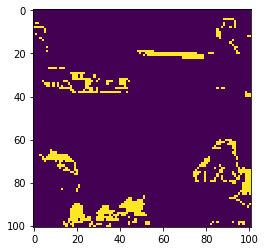

In [108]:


for i in range(10):
    focus = data[i]
    focus_2d = focus.sum(axis=2)
    print (i)
    plt.imshow(focus)
    plt.show()
    checkPlot(focus_2d)
    print()
    
    

In [133]:
def preprocess_and_extract_features(data):
    '''Preprocess data and extract features

    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.

    # Make the image grayscale
    #data = rgb2grey(data)
    #data[data > 140] = 255
    
#     # Vectorize the grayscale matrices
#     vectorized_data = data.reshape(data.shape[0],-1)
#     features = vectorized_data
    
#     # extract the mean and standard deviation of each sample as features
#     feature_mean = np.mean(vectorized_data,axis=1)
#     feature_std  = np.std(vectorized_data,axis=1)
    
#     # Combine the extracted features into a single feature vector
#     features = np.stack((feature_mean,feature_std),axis=-1)
    
    
    hog_feature_list = []
    for i in range(len(data)):
        # extract hog features of each sample
        hog_features = hog(data[i], block_norm='L2-Hys', pixels_per_cell=(16, 16), feature_vector=True)
        hog_feature_list.append(hog_features) 
    features = np.array(hog_feature_list)

    
    return features


In [148]:
def set_classifier(model = ['RF', 10] ):
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''    

    if model[0] == 'SVC':
        if len(model) > 1:
            return SVC(C = model[1], probability=True)        
        else:
            return SVC(probability=True)
        
    if model[0] == 'SVC2':
        return SVC(degree = 2, probability=True)
    
    if model[0] == 'SVC4':
        return SVC(degree = 4, probability=True)
    
    if model[0] == 'LinearSVC':
        return LinearSVC(probability=True)
    
    if model[0] == 'LR':
        return LogisticRegression()
    
    if model[0] == 'NN':
        return MLPClassifier()
    
    if model[0] == 'NN1':
        return MLPClassifier(hidden_layer_sizes=(200, ))

    if model[0] == 'NN2':
        return MLPClassifier(hidden_layer_sizes=(100, 100,))
    
    if model [0] == 'XGB':
        if len(model) > 1:
            return XGBClassifier(n_estimators=model[1])
        else:
            return XGBClassifier()
    
    if model[0] == 'RF':
        if len(model) == 2:
            return RandomForestClassifier(n_jobs=2, n_estimators=model[1], random_state=0)
        elif len(model) == 3:
            return RandomForestClassifier(n_jobs=2, n_estimators=model[1], depth = model[2], random_state=0)
    
    if model[0] =='KNN':
        return KNeighborsClassifier(25)

    print ('no model found!')

In [150]:
def cv_performance_assessment(X_features,y,k,clf):
    '''Cross validated performance assessment

    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores_train = np.empty(y.shape[0],dtype='object')
    prediction_scores_val = np.empty(y.shape[0],dtype='object')
    
    
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X_features, y):
        # Extract the training and validation data for this fold
        X_train_features, X_val_features   = X_features[train_index], X_features[val_index]
        y_train          = y[train_index]

        # Train the classifier
        #X_train_features = preprocess_and_extract_features(X_train)        
        clf              = clf.fit(X_train_features,y_train)

        # Test the classifier on the validation data for this fold
        #X_val_features   = preprocess_and_extract_features(X_val)
        
        
        cpred_train      = clf.predict_proba(X_train_features)
        cpred_val        = clf.predict_proba(X_val_features)

        # Save the predictions for this fold
        prediction_scores_train[train_index] = cpred_train[:,1]
        prediction_scores_val[val_index] = cpred_val[:,1]
    return prediction_scores_train, prediction_scores_val

In [149]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)

    if False:
        plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
        plt.plot(fpr, tpr, label=legend_string)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid('on')
        plt.axis('square')
        plt.legend()
        plt.tight_layout()
    return round(auc * 100, 1)

In [151]:
import warnings
warnings.filterwarnings('ignore')

for model in [['SVC',10]]:#[['RF', 10], ['RF', 50], ['SVC'] ]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores_val = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc_train = plot_roc(labels, prediction_scores_train)
    auc_val = plot_roc(labels, prediction_scores_val)
    print (model, auc_train, auc_val)

KeyboardInterrupt: 

In [92]:
for model in [['RF', 100], ['RF', 150], ['RF', 70], ['RF', 40]]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores_val = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc_val = plot_roc(labels, prediction_scores_val)
    auc_train = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['RF', 100] 100.0 77.9
['RF', 150] 100.0 77.3
['RF', 70] 100.0 77.6
['RF', 40] 100.0 74.3


In [96]:
for model in [['NN1'], ['NN2']]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['NN1'] 100.0 80.0
['NN2'] 100.0 80.6


In [98]:
for model in [['SVC', 0.1], ['SVC', 10]]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['SVC', 0.1] 90.9 80.4
['SVC', 10] 100.0 83.8


In [18]:
for model in [['SVC', 0.5]]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['SVC', 0.5] 95.7 82.6


In [77]:
for model in [['SVC4']]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['SVC4'] 62.0 57.4


In [28]:
for model in [['XGB']]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['XGB'] 100.0 78.5


In [30]:
for model in [['XGB', 10], ['XGB', 20], ['XGB', 40], ['XGB', 80]]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['XGB', 10] 89.6 70.8
['XGB', 20] 94.6 74.2
['XGB', 40] 98.6 76.6
['XGB', 80] 99.9 78.2


In [35]:
for model in [['XGB', 200]]:
    clf = set_classifier(model)
    prediction_scores_train, prediction_scores = cv_performance_assessment(data_features,labels,num_training_folds,clf)
    auc = plot_roc(labels, prediction_scores)
    auc_t = plot_roc(labels, prediction_scores_train)
    print (model, auc_t, auc)

['XGB', 200] 100.0 80.0


### PCA + HOG FEATURE STAKCK


### HOG PARAMETER
### DATA AUGMENTATION (ROTATE, RESIZE, CLIP)

### Sample script

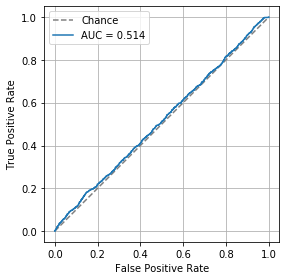

In [122]:
'''
Sample script for cross validated performance
'''
# Set parameters for the analysis
num_training_folds = 20

# Load the data
#data, labels = load_data(dir_train_images, dir_train_labels, training=True)

# Choose which classifier to use
clf = set_classifier(model = ['KNN', 10])

# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(data, labels, num_training_folds, clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

### Submission

In [10]:
'''
Sample script for producing a Kaggle submission
'''

produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission:
    # Load data, extract features, and train the classifier on the training data
    training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    training_features              = preprocess_and_extract_features(training_data)
    clf                            = set_classifier(model=['SVC2', 10])
    clf.fit(training_features,training_labels)

    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
    test_features  = preprocess_and_extract_features(test_data)
    test_scores    = clf.predict_proba(test_features)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission.csv',
                           columns=['id','score'],
                           index=False)